#### 데이터 로딩

In [16]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

train_df = pd.read_csv("../data/processed/train.csv")
val_df = pd.read_csv("../data/processed/val.csv")
test_df = pd.read_csv("../data/processed/test.csv")

X_train = train_df.drop(columns=["Rented_Bike_Count"]).values
y_train = train_df["Rented_Bike_Count"].values

X_test = test_df.drop(columns=["Rented_Bike_Count"]).values
y_test = test_df["Rented_Bike_Count"].values

results = []

#### 평가 함수

In [17]:
def print_metrics(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}]")
    print(f"  MSE : {mse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R²  : {r2:.4f}")
    print("-" * 30)

def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    })


#### 선형 회귀

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print_metrics("Linear Regression", y_test, y_pred_lr)
evaluate_model("Linear Regression", y_test, y_pred_lr)

[Linear Regression]
  MSE : 217475.75
  MAE : 343.93
  R²  : 0.4780
------------------------------


#### 결정 트리

In [19]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_dt = grid.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print_metrics("Decision Tree", y_test, y_pred_dt)
evaluate_model("Decision Tree", y_test, y_pred_dt)

[Decision Tree]
  MSE : 110257.50
  MAE : 192.45
  R²  : 0.7354
------------------------------


#### 랜덤 포레스트

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print_metrics("Random Forest", y_test, y_pred_rf)
evaluate_model("Random Forest", y_test, y_pred_rf)

[Random Forest]
  MSE : 70224.39
  MAE : 140.23
  R²  : 0.8315
------------------------------


#### Gradient Boosting

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

gbr = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

print_metrics("Gradient Boosting", y_test, y_pred_gbr)
evaluate_model("Gradient Boosting", y_test, y_pred_gbr)


[Gradient Boosting]
  MSE : 60553.86
  MAE : 141.19
  R²  : 0.8547
------------------------------


#### AdaBoost

In [22]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

base = DecisionTreeRegressor(max_depth=5)
ada = AdaBoostRegressor(
    estimator=base,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

print_metrics("AdaBoost", y_test, y_pred_ada)
evaluate_model("AdaBoost", y_test, y_pred_ada)


[AdaBoost]
  MSE : 111530.68
  MAE : 226.23
  R²  : 0.7323
------------------------------


#### 결과 비교 테이블 및 시각화

,Model,MSE,MAE,R2
0,Linear Regression,217475.752074,343.928902,0.478033
1,Decision Tree,110257.495761,192.445089,0.735369
2,Random Forest,70224.388983,140.226825,0.831453
3,Gradient Boosting,60553.860207,141.185438,0.854664
4,AdaBoost,111530.680679,226.226174,0.732313


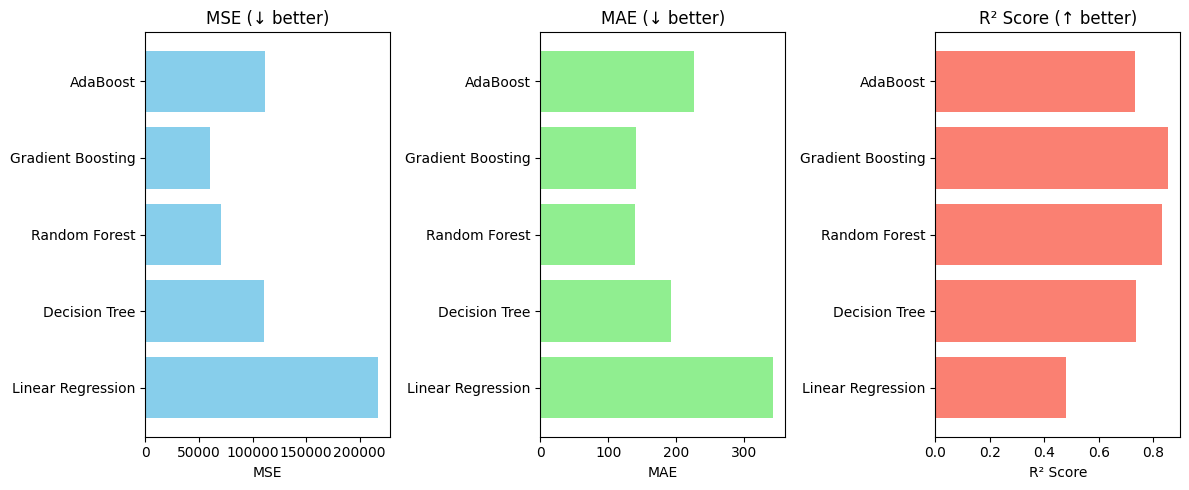

In [24]:
df_results = pd.DataFrame(results)
display(df_results)

import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 5))

# MSE 그래프
plt.subplot(1, 3, 1)
plt.barh(df_results["Model"], df_results["MSE"], color='skyblue')
plt.title("MSE (↓ better)")
plt.xlabel("MSE")

# MAE 그래프
plt.subplot(1, 3, 2)
plt.barh(df_results["Model"], df_results["MAE"], color='lightgreen')
plt.title("MAE (↓ better)")
plt.xlabel("MAE")

# R² Score 그래프
plt.subplot(1, 3, 3)
plt.barh(df_results["Model"], df_results["R2"], color='salmon')
plt.title("R² Score (↑ better)")
plt.xlabel("R² Score")

plt.tight_layout()
plt.show()
